In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../embo')
sys.path.append('../predinfo')
from embo.embo import empirical_bottleneck as eb
from scipy.stats import spearmanr as corr
from scipy.stats import ranksums

In [2]:
filename = "Data/RL_MDD_All.csv"
data_file = pd.read_csv(filename)


In [94]:
depressed = data_file.groupby(['Subject']).agg({'Group': lambda x: x.iloc[0]})
depressed.head()

,Group
Subject,
1210,MDD
1211,MDD
1212,MDD
1213,MDD
1214,MDD


In [4]:
my_concat = lambda x: list(x.values)
agg_df = data_file.groupby(['Subject']).agg({
    'SubChoice':my_concat,
    'Reward' : my_concat,
    'RichFrac' : my_concat
}).reset_index()

In [95]:
agg_df.head()

,Subject,Reward,SubChoice,RichFrac
0,1210,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ...","[2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1211,"[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, ...","[2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1212,"[1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1213,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, ...","[1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 1, 2, ...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
4,1214,"[1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, ...","[2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [25]:
def trial_label(x):
    as_strings = [num.astype(str) for num in x]
    return "".join(as_strings)

def make_features(trials_data):
    labeled_data = np.apply_along_axis(trial_label, 0, trials_data)
    combos = np.unique(labeled_data)
    string_to_index = dict(zip(combos, np.arange(len(combos))))
    map_to_index = np.vectorize(lambda x: string_to_index[x])
    mapped_data = map_to_index(labeled_data)
    return mapped_data

def get_marginal(x):
    """
    Helper function to compute and return marginal probability distribution for a 1d vector (x)
    """
    px = np.array([np.sum(x==xi) 
                      for xi in np.unique(x)])/len(x)
    return px

def get_joint(x, y):
    """
    Computes joint probability distribution between 1d vectors x and y
    """
    #  set up dictionary for joint distribution (x-->y-->freq)
    joint_x_y = {}
    
    for x_un in np.unique(x):
        joint_x_y[x_un] = dict(zip(np.unique(y), np.zeros(len(np.unique(y)))))
        
#    populate dictionary 
    for trial, x_val in enumerate(x):
        y_val = y[trial]
        joint_x_y[x_val][y_val] += 1
        
#   normalize to make distirbution  
    joint_sum = sum(sum(list(c.values())) for c in list(joint_x_y.values()))
    
    for key1 in joint_x_y:
        for key2 in joint_x_y[key1]:
            joint_x_y[key1][key2] /= joint_sum
            
    return joint_x_y

def mutual_inf(x, y):
    """
    Calculates the mutual information I(x;y)
    Assuming x,y are both [n x 1] dimensional
    """  
#     Calculate marginal distributions
    px = get_marginal(x)
    py = get_marginal(y)
    
    
    joint_x_y = get_joint(x,y)
# calculate mutual information
    mi = 0
    
    for n_x, x_un in enumerate(np.unique(x)):
        pxi = px[n_x] # p(x)
        
        for n_y, y_un in enumerate(np.unique(y)):
            pyi = py[n_y] # p(y)            
            
            joint_i = joint_x_y[x_un][y_un] # P(x,y)
            
            if ((pxi == 0) or (pyi == 0) or (joint_i ==0 )):
                continue
            else:
                mi += joint_i * np.log2(joint_i/(pxi*pyi))
                
    return mi

def deltaBound(ib_ipast,ib_ifuture,p_ipast,p_ifuture):
    ''' Function to calculate distance from the bound between an empirical IB and participant predictive info
    ib_ipast: ipast of empirical IB (x of convex hull)
    ib_ifuture: ifuture of empirical IB (y of convex hull)
    p_ipast: participant ipast (uncorrected)
    p_ifuture: participant ifuture (uncorrected)
    
    Returns participant ifuture minus the empirical bound (more negative = farther away from the bound)
    '''
    ind = np.argwhere(np.array(ib_ipast) > p_ipast)[0][0]
    slp = (ib_ifuture[ind]-ib_ifuture[ind-1])/(ib_ipast[ind]-ib_ipast[ind-1])
    intercept = ib_ifuture[ind]-(slp*ib_ipast[ind])
    #Return distance between participant Ifuture and interpolated bound - higher 
    return p_ifuture - ((p_ipast*slp)+intercept)


# FUNCTIONS TO COMPUTE CONVEX HULL
def split(u, v, points):
    # return points on left side of UV
    return [p for p in points if np.cross(p - u, v - u) < 0]

def extend(u, v, points):
    if not points:
        return []

    # find furthest point W, and split search to WV, UW
    w = min(points, key=lambda p: np.cross(p - u, v - u))
    p1, p2 = split(w, v, points), split(u, w, points)
    return extend(w, v, p1) + [w] + extend(u, w, p2)

def convex_hull(points):
    # find two hull points, U, V, and split to left and right search
    u = min(points, key=lambda p: p[0])
    v = max(points, key=lambda p: p[0])
    left, right = split(u, v, points), split(v, u, points)

    # find convex hull on each side
    return [v] + extend(u, v, left) + [u] + extend(v, u, right) + [v]

In [7]:
def mi_per_subject(subject_data):
#     trial_data = np.array([subject_data['Reward'].values, subject_data['SubChoice'].values])
    trial_data = np.array([[(subject_data['Reward'].values)[0]], 
                           [(subject_data['SubChoice'].values)[0]], 
                           [(subject_data['RichFrac'].values)[0]]])

    trial_data = trial_data.squeeze()
    features = make_features(trial_data)
    resp = trial_data[1,:]
    
#     1 Back version
    predInfo = [mutual_inf(features[:-1],resp[1:]),mutual_inf(features[1:],resp[:-1])]
    
#   2 Back version
#     predInfo = [mutual_inf(features[:-2],resp[2:]),mutual_inf(features[1:],resp[:-1])]
    
    Fpast = features[:-1]
    Ffuture = features[1:]
    #  >>>>THIS LINE TAKES A LONG TIME TO RUN   
    i_p,i_f,beta,mi,hx,hy = eb(Fpast,Ffuture,numbeta=3000,maxbeta=50)
    #  <<<<< THIS LINE TAKES A LONG TIME TO RUN 
    return (predInfo,i_p,i_f,mi)

In [93]:

"""
This code is run on the cluster instead due to performance issues with the method above
"""
# sub_dict = {}
# N = len(np.unique(agg_df['Subject']))
# for i,subject in enumerate(np.unique(agg_df['Subject'])):
#     print('Subject # %s/%s' % (i+1, N))
#     sub_dict[subject] = {}
#     sub_dict[subject]['Subject'] = subject
#     mi,i_p, i_f,saturation = mi_per_subject(agg_df[agg_df['Subject']==subject])
    
#     sub_dict[subject]['Ipast'] = mi[0]
#     sub_dict[subject]['Ifuture'] = mi[1]
#     sub_dict[subject]['i_p'] = i_p
#     sub_dict[subject]['i_f'] = i_f
#     sub_dict[subject]['saturation'] = saturation
    
# np.save('bounds_one_back.npy', sub_dict)



'\nThis code is run on the cluster instead due to performance issues with the method above\n'

In [20]:
"""
THIS LOADS THE DATA THAT WAS COMPUTED ON THE CLUSTER AND SAVED IN "Data" directory
"""
sub_load = {**np.load('Data/bounds_one_back.npy').item(), 
            **np.load('Data/bounds_one_back_second_set.npy').item(),
            **np.load('Data/bounds_one_back_third_set.npy').item()
           }
sub_dict=sub_load


In [21]:
sub_to_mi_df = pd.DataFrame.from_dict(sub_dict, orient='index')

In [96]:
merged_df= sub_to_mi_df.join(depressed ,lsuffix='_caller', rsuffix='_other')
merged_df.head()

,Ipast,i_p,i_f,saturation,Subject,Ifuture,Group
1210,0.047298,"[3.647437907261519e-11, 6.750910941377697e-11,...","[3.3015368217093055e-11, 6.110756345378832e-11...",0.902672,1210,0.052794,MDD
1211,0.457982,"[7.577671823355558e-11, 1.4025980377141423e-10...","[5.615197196107147e-11, 1.0393819138698746e-10...",1.277341,1211,0.261090,MDD
1212,0.039991,"[3.8770764376749867e-11, 7.176303995493072e-11...","[3.4014568939255696e-11, 6.295897136965323e-11...",1.019407,1212,0.046290,MDD
1213,0.034447,"[3.324451824937569e-11, 6.153300091682468e-11,...","[3.029931860965007e-11, 5.608002950907576e-11,...",0.914443,1213,0.012089,MDD
1214,0.037241,"[6.601164059816256e-11, 1.2217560296789998e-10...","[5.973088690325312e-11, 1.1055290016770414e-10...",0.897060,1214,0.027169,MDD


In [23]:
merged_df.groupby(['Group']).count()

,Ipast,i_p,i_f,saturation,Subject,Ifuture
Group,,,,,,
Healthy Controls,64,64,64,64,64,64
MDD,64,64,64,64,64,64


In [91]:
merged_df.groupby(['Group']).mean()

,Ipast,saturation,Subject,Ifuture
Group,,,,
Healthy Controls,0.317342,1.133968,1432.5,0.166082
MDD,0.210126,1.070178,1241.5,0.121341


In [65]:
"""
Method for computing distances from the bound for each subject

"""
def get_delta_subject(subject_data):
    i_p = subject_data['i_p'].values[0]
    i_f = subject_data['i_f'].values[0]
    
    points = np.stack([i_p,i_f],axis=1)
    hull = np.array(convex_hull(points))
    
    distance= deltaBound(np.flip(hull[0:-1,0],0),np.flip(hull[0:-1,1],0),
                         subject_data['Ipast'].values[0], subject_data['Ifuture'].values[0])
    return distance


# 
MDD_data = merged_df[merged_df['Group']=='MDD']
MDD_x = MDD_data['Ipast'].values
MDD_y = np.zeros(len(MDD_data))
print('distances for MDD')
for i, subject in enumerate(MDD_data.iterrows()):
    print("%s/%s" % (i+1,len(control_data)))
    s = MDD_data[MDD_data['Subject']==subject[0]]
    distance = get_delta_subject(s)
    MDD_y[i] = distance
    assert(subject[1]['Ipast']==MDD_x[i])

control_data = merged_df[merged_df['Group']=='Healthy Controls']

# 
control_x = control_data['Ipast'].values
control_y = np.zeros(len(control_data))
print('distances for controls')
for i, subject in enumerate(control_data.iterrows()):
    print("%s/%s" % (i+1,len(control_data)))
    s = control_data[control_data['Subject']==subject[0]]
    distance = get_delta_subject(s)
    control_y[i] = distance
    assert(subject[1]['Ipast']==control_x[i])

    
#     s = merged_df[merged_df['Subject']==subject]
#     distances[subject]= get_delta_subject(s)
    
    

distances for MDD
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64
64/64
distances for controls
1/64
2/64
3/64
4/64
5/64
6/64
7/64
8/64
9/64
10/64
11/64
12/64
13/64
14/64
15/64
16/64
17/64
18/64
19/64
20/64
21/64
22/64
23/64
24/64
25/64
26/64
27/64
28/64
29/64
30/64
31/64
32/64
33/64
34/64
35/64
36/64
37/64
38/64
39/64
40/64
41/64
42/64
43/64
44/64
45/64
46/64
47/64
48/64
49/64
50/64
51/64
52/64
53/64
54/64
55/64
56/64
57/64
58/64
59/64
60/64
61/64
62/64
63/64
64/64


# RESULTS

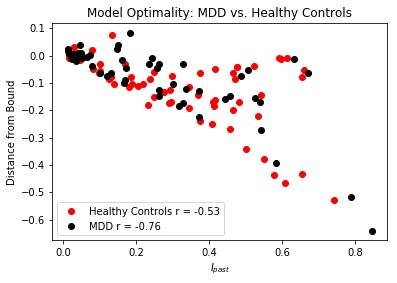

In [75]:
plt.figure()
plt.plot(control_x, control_y, 'ro', label='Healthy Controls r = %.2f' % corr(control_x,control_y)[0])
plt.xlabel('$I_{past}$')
plt.ylabel('Distance from Bound')

plt.plot(MDD_x, MDD_y, 'ko', label='MDD r = %.2f' % corr(MDD_x,MDD_y)[0])



plt.legend()
plt.title('Model Optimality: MDD vs. Healthy Controls')
plt.savefig('Optimality')
plt.show()

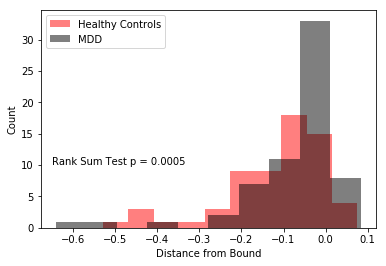

In [97]:
plt.figure()
plt.hist(control_y, 10, facecolor='r', alpha=.5)
plt.hist(MDD_y, 10, facecolor='k', alpha=.5)
plt.legend(['Healthy Controls', 'MDD'])
plt.ylabel('Count')
plt.xlabel('Distance from Bound')
plt.text(-.65, 10, 'Rank Sum Test p = %.4f' % ranksums(control_y, MDD_y)[1])
plt.savefig('Distance Distributions')
plt.show()

In [58]:
MDD_x = MDD_data['Ipast']
np.shape(MDD_x.values)

subject[1]['Ipast']

0.047297996781606545

In [226]:
distances

[0.011918290897651548,
 0.009330775198360342,
 0.02138465621941276,
 -0.018406438597189975,
 0.0025045066066845187,
 -0.24481401842550532,
 0.01387788127923769,
 0.08937298988992454,
 -0.0043677538242527895,
 0.09432947252542281,
 -0.006138622894934623,
 -0.0002171740172650094,
 -0.0014616640272168344,
 -0.06742303128360783,
 0.05096042029145095,
 -0.03582132928708921,
 -0.0024388788473959713,
 0.0031366841153950137,
 0.00573196363008213,
 -0.0963588557537233,
 0.10266744438435554,
 0.017115524375070475,
 0.04367664197213374,
 -0.015648218029275636,
 0.14722939201607205,
 -0.03313856399245782,
 -0.031169066401738575,
 0.13378292409445025,
 0.06531692686415266,
 -0.0014200978646748408,
 0.005808207450923891,
 0.005358900238369657,
 0.005709436693968145,
 0.021273291964088004,
 -0.03308942144949906,
 0.03136377851756844,
 0.0044443972110405836,
 -0.3765125308137025,
 0.016652969685893367,
 -0.026924607100730844,
 -0.034383167584791395,
 -0.10530775794450314,
 0.024937854743835808,
 0.089

## Plots to Make

### Distance From Bound, Healthy vs. MDD in different colors
#### mean distance from bound different?
#### correlation different?

### Normalizing Bounds by Saturation Point (divide both information vectors by that point)
#### repeat above, but also divide each subject's Ipast,Ifuture with the SP

